<a href="https://colab.research.google.com/github/ericburdett/hwr/blob/master/notebook-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple HWR - TensorFlow
Implementation of Gated Convolutional Recurrent Neural Network for Handwriting Recognition as recorded in [Bluche](http://ieeexplore.ieee.org/document/8270042/).

### Imports and Setup

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
from google.colab import drive
from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!cp "drive/My Drive/datasets/iam.zip" "/content"
!unzip -q iam.zip
!rm iam.zip

warning [iam.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [iam.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #95170).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


### Dataset and Helper Functions

In [0]:
class Encoder():
  # input => (tuple of strings)
  def get_representation(words):
    charlists = []
    zeros = np.zeros(20)

    if type(words) == str:
      charlist = [ord(c) for c in words]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

      return np.array(charlists)

    for word in words:
      charlist = [ord(c) for c in word]
      charlist = np.concatenate((charlist, zeros))
      charlists.append(charlist[:16])

    return np.array(charlists)

  def get_strings(tensor):
    words = []

    for indices in tensor:
      word = ''

      for index in indices:
        if index.item() != 0:
          letter = chr(index.item())
          word += letter
      
      words.append(word)

In [0]:
def show_imgs(x, new_fig=True):
  if new_fig:
    plt.figure()
  plt.imshow(x)
  plt.pause(1)

def resize_img(img, desired_size):
  img_size = np.array(img).shape

  img_ratio = img_size[0] / img_size[1]
  desired_ratio = desired_size[0] / desired_size[1]

  if img_ratio >= desired_ratio:
    # Solve by height
    new_height = desired_size[0]
    new_width = int(desired_size[0] // img_ratio)
  else:
    new_height = int(desired_size[1] * img_ratio)
    new_width = desired_size[1]
    # Solve by width

  img = np.array(img.resize((new_width, new_height)))

  border_top = desired_size[0] - new_height
  border_right = desired_size[1] - new_width

  border_img = cv2.copyMakeBorder(
      img,
      top=border_top,
      bottom=0,
      left=0,
      right=border_right,
      borderType=cv2.BORDER_CONSTANT,
      value=[255]
  )

  return border_img

def tensor_image(path, desired_size):
  img = Image.open(path + '.png')
  img = resize(img, desired_size)
  x = np.array(img)

  return x

def get_dataset_df(path='/content/labels.csv'):
  if not os.path.exists(path):
    raise Exception('Iam dataset does not exist in ' + path)

  df = pd.read_csv(path, sep='\t', header=None, names=['word', 'seg', 'transcription'])
  df = df.drop(['seg'], axis=1)
  df = df.drop(df[df['transcription'] == '.'].index)
  df = df.drop(df[df['transcription'] == '!'].index)
  df = df.drop(df[df['transcription'] == ','].index)
  df = df.drop(df[df['transcription'] == ';'].index)
  df = df.drop(df[df['transcription'] == ':'].index)    
  df = df.drop(df[df['transcription'] == ')'].index)
  df = df.drop(df[df['transcription'] == '('].index)
  df = df.sample(frac=1) # shuffle all rows in the dataframe
  df = df.reset_index()

  return df

def iam_generator(desired_size=(32, 128)):
  df = get_dataset_df()

  for index, row in df.iterrows():
    path = 'images/' + row['word'] + '.png'
    img = Image.open(path)
    img = resize_img(img, desired_size)
    x = tf.expand_dims(tf.convert_to_tensor(np.array(img), dtype=tf.float32), 2)
    y = tf.convert_to_tensor(Encoder.get_representation(row['transcription']), dtype=tf.int32)

    yield(x, y)

### Recognition Model

In [0]:
class Recognizer(Model):
  def __init__(self):
    super(Recognizer, self).__init__()
    
    # Encoder
    self.conv1 = L.Conv2D(8, 3, strides=1, padding='same', activation='tanh')
    self.conv2 = L.Conv2D(16, 3, strides=1, padding='same', activation='tanh')
    self.conv3 = L.Conv2D(32, 3, strides=1, padding='same', activation='tanh')
    self.conv4 = L.Conv2D(64, 3, strides=1, padding='same', activation='tanh')
    self.conv5 = L.Conv2D(128, 3, strides=1, padding='same', activation='tanh')

    self.gate1 = L.Conv2D(16, 3, strides=1, padding='same', activation='sigmoid')
    self.gate2 = L.Conv2D(32, 3, strides=1, padding='same', activation='sigmoid')
    self.gate3 = L.Conv2D(64, 3, strides=1, padding='same', activation='sigmoid')

    # MaxPool
    self.mp = L.MaxPool2D((32, 1))

    # Decoder
    self.gru1 = L.Bidirectional(L.GRU(256, return_sequences=True))
    self.fc1 = L.Dense(128)
    self.gru2 = L.Bidirectional(L.GRU(256, return_sequences=True))
    self.fc2 = L.Dense(16)
    self.permute = L.Permute((2, 1))

  def call(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.conv2(out)

    g1 = self.gate1(out)
    out = out * g1

    out = self.conv3(out)
    
    g2 = self.gate2(out)
    out = out * g2

    out = self.conv4(out)

    g3 = self.gate3(out)
    out = out * g3

    out = self.conv5(out)

    # Max Pooling across vertical dimension
    out = self.mp(out)

    # Decoder
    out = tf.reshape(out, [-1, 128, 128])

    out = self.gru1(out)
    out = self.fc1(out)
    out = self.gru2(out)
    out = self.fc2(out)
    out = self.permute(out)

    return out

### Training

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    batch_size = images.shape[0]
    input_lengths = tf.constant(np.full((batch_size,), 16))
    label_lengths = tf.squeeze(tf.math.count_nonzero(labels, axis=2))
    labels = tf.squeeze(labels, axis=1)
    
    predictions = model(images)

    loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths, logits_time_major=False)
    loss = tf.reduce_mean(loss)
  
  gradients = tape.gradient(loss, model.trainable_variables)
  # gradients = [grads if grads is not None else tf.zeros_like(var) for var, grads in zip(model.trainable_variables, gradients)] # If gradients are None, set them to zero
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

@tf.function
def test_step(images, labels):
  batch_size = images.shape[0]
  input_lengths = tf.constant(np.full((batch_size,), 16))
  label_lengths = tf.squeeze(tf.math.count_nonzero(labels, axis=2))
  labels = tf.squeeze(labels, axis=1)

  predictions = model(images)

  loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths, logits_time_major=False)
  loss = tf.reduce_mean(loss)

  test_loss(loss)

In [31]:
EPOCHS = 15
BATCH_SIZE = 250
ITERATION_SAMPLE = 100

K.clear_session()

dataset_size = len(get_dataset_df())
test_dataset_size = int(.3 * dataset_size)
train_dataset_size = dataset_size - test_dataset_size

dataset = tf.data.Dataset.from_generator(
    iam_generator,
    (tf.float32, tf.int32),
    (tf.TensorShape([None, None, 1]), tf.TensorShape([None, 16]))
)
test_dataset = dataset.take(test_dataset_size).batch(BATCH_SIZE)
train_dataset = dataset.skip(test_dataset_size).batch(BATCH_SIZE)

model = Recognizer()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

for epoch in range(EPOCHS):
  train_loss.reset_states()
  test_loss.reset_states()

  # Train Step
  train_loop = tqdm(total=train_dataset_size//BATCH_SIZE, position=0, leave=True)
  for iteration_num, (images, labels) in enumerate(train_dataset):
    train_step(images, labels)
    train_loop.set_description('Train - Epoch: {}, Loss: {}'.format(epoch, train_loss.result()))
    train_loop.update(1)

  train_loop.close()

  # Test Step
  test_loop = tqdm(total=test_dataset_size//BATCH_SIZE, position=0, leave=True)
  for iteration_num, (images, labels) in enumerate(test_dataset):
    test_step(images, labels)
    test_loop.set_description('Test - Epoch: {}, Loss: {}'.format(epoch, test_loss.result()))
    test_loop.update(1)

  test_loop.close()

Train - Epoch: 0, Loss: 20.897790908813477: : 241it [05:23,  1.34s/it]
Test - Epoch: 0, Loss: 18.088346481323242: : 104it [01:05,  1.59it/s]
Train - Epoch: 1, Loss: 16.944801330566406: : 241it [05:18,  1.32s/it]
Test - Epoch: 1, Loss: 16.44864273071289: : 104it [01:03,  1.64it/s]
Train - Epoch: 2, Loss: 16.07830810546875: : 241it [05:13,  1.30s/it]
Test - Epoch: 2, Loss: 15.562849044799805: : 104it [01:02,  1.66it/s]
Train - Epoch: 3, Loss: 15.452164649963379: : 241it [05:14,  1.31s/it]
Test - Epoch: 3, Loss: 14.668404579162598: : 104it [01:04,  1.62it/s]
Train - Epoch: 4, Loss: 15.250085830688477: : 241it [05:17,  1.32s/it]
Test - Epoch: 4, Loss: 15.090216636657715: : 104it [01:02,  1.67it/s]
Train - Epoch: 5, Loss: 15.164883613586426: : 241it [05:15,  1.31s/it]
Test - Epoch: 5, Loss: 14.867731094360352: : 104it [01:03,  1.64it/s]
Train - Epoch: 6, Loss: 14.725492477416992: : 241it [05:22,  1.34s/it]
Test - Epoch: 6, Loss: 14.442957878112793: : 104it [01:04,  1.60it/s]
Train - Epoch: 

### Results

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['Io']
Target:  ['A']


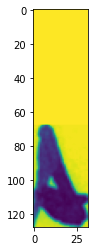

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['erem']
Target:  ['stop']


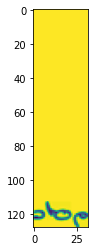

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['fmn']
Target:  ['from']


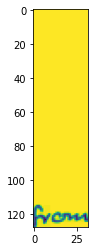

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['mneei']
Target:  ['more']


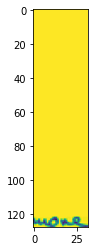

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['Teno']
Target:  ['Peers']


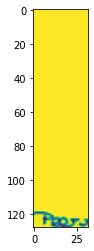

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['deet']
Target:  ['be']


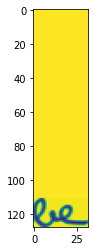

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['anf']
Target:  ['a']


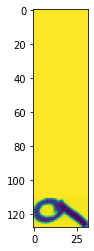

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['weno']
Target:  ['Labour']


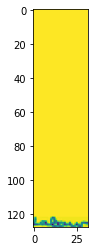

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['aon']
Target:  ['a']


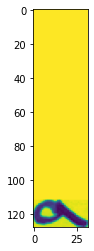

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['tefe']
Target:  ['the']


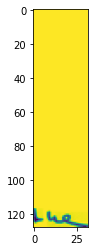

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['uso']
Target:  ['M']


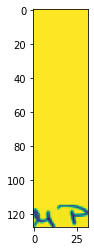

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['cemeo']
Target:  ['Exchange']


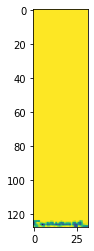

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['ir']
Target:  ['to']


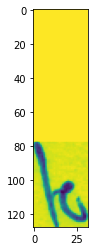

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['hibeni']
Target:  ['Gaitskell']


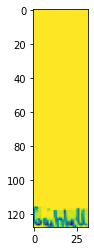

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['mye']
Target:  ['any']


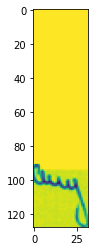

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['bfn']
Target:  ['life']


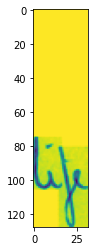

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['te']
Target:  ['to']


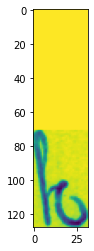

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['ae']
Target:  ['at']


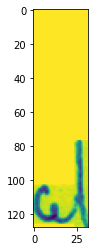

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['iei']
Target:  ['of']


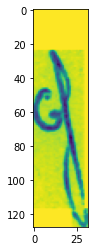

/Job:Localhost/Replica:0/Task:0/Device:Cpu:0
Predicted:  ['tosee']
Target:  ['tomorrow']


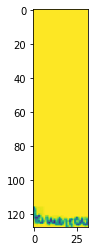

In [0]:
val_dataset = dataset.batch(3)
for iteration_num, (images, labels) in enumerate(val_dataset):
  if iteration_num == 20:
    break

  input_lengths = tf.constant(np.full((3,), 16), dtype=tf.int32)
  preds = model(images)

  decoded, _ = tf.nn.ctc_greedy_decoder(tf.reshape(preds, (16, -1, 128)), input_lengths)
  preds_strings = convert_to_strings_with_decoder(decoded)
  target_strings = convert_to_strings(labels)

  print('Predicted: ', preds_strings[:1])
  print('Target: ', target_strings[:1])
  show_imgs(tf.squeeze(images[:1]))
  plt.pause(1)

### CTC-Loss Example

In [0]:
tf.device()

In [0]:
with tf.device("GPU:0"):
  vectors = tf.constant(np.array([[97, 98, 99, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [65, 66, 67, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))
  print(vectors)
  print(vectors.device.title())
  print(convert_to_strings(vectors))

tf.Tensor(
[[ 97  98  99 100   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 65  66  67  68   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(2, 16), dtype=int64)
/Job:Localhost/Replica:0/Task:0/Device:Gpu:0
/Job:Localhost/Replica:0/Task:0/Device:Gpu:0
['abcd', 'ABCD']


In [0]:
def decode(index_num):
  return chr(index_num)

In [0]:
def convert_to_strings_with_decoder(decoded):
  values = decoded[0].values.numpy()
  indices = decoded[0].indices.numpy()

  words = []

  current_index = 0
  current_word = ''

  for index, value in zip(indices, values):
    if index[0] == current_index:
      if value != 0:
        current_word += decode(value)
    else:
      current_index = index[0]
      words.append(current_word)
      if value != 0:
        current_word = decode(value)
      else:
        current_word = ''
  
  words.append(current_word)
  
  return words

def convert_to_strings(vectors):
  print(vectors.device.title())
  vectors = tf.reshape(vectors, [-1, 16])
  vectors = vectors.numpy()

  words = []

  for vector in vectors:
    word = ''

    for char in vector:
      if char != 0:
        word += decode(char)
    
    words.append(word)
  
  return words

In [0]:
labels = tf.constant(np.random.randint(low=0, high=128, size=(2, 16)))
preds = tf.constant(np.random.randn(2, 16, 128), dtype=tf.float32)
llengths = tf.constant(np.random.randint(low=0, high=16, size=(2)), dtype=tf.int32)
ilengths = tf.constant(np.full((2,), 16), dtype=tf.int32)

# print('labels: ', labels.shape)
# print('preds: ', preds.shape)
# print(preds)
# print('input lengths: ', ilengths.shape)
# print('label lengths: ', llengths.shape)
decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(tf.reshape(preds, (16, -1, 128)), ilengths)
print('decode: ', decoded[0])
print('ctc-loss: ', tf.reduce_mean(tf.nn.ctc_loss(labels, preds, llengths, ilengths, logits_time_major=False, blank_index=0)))

decode:  SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]], shape=(32, 2), dtype=int64), values=tf.Tensor(
[122 112  31 122  85  15 125  74 110 109  44 107 120  81 110 104 104  24
   3  76  46  71 125 124  15 102 111 122  55  37  77 108], shape=(32,), dtype=int64), dense_shape=tf.Tensor([ 2 16], shape=(2,), dtype=int64))
Instructions for updating:
Prefer tf.tensor_scatter_nd_add, which offers the same functionality with well-defined read-write semantics.
Instructions for updating:
Prefer tf.tensor_scatter_nd_update, which offers the same functionality with well-defined read-write semantics.
ctc-loss:  tf.Tensor(71.71604, shape=(), dtype=float32)


In [0]:
convert_to_strings_with_decoder(decoded)

OperatorNotAllowedInGraphError: ignored